# Unit11_Support_Vector_Machine | 支持向量機回歸：反應器溫度預測

本 Notebook 使用模擬數據建立支持向量機回歸 (SVR) 模型來預測連續攪拌槽反應器 (CSTR) 的出口溫度。

## 學習目標
- 理解支持向量機回歸的 ε-insensitive loss 機制
- 掌握核函數 (Kernel Functions) 的概念與應用
- 使用 `sklearn.svm.SVR` 建立線性與非線性回歸模型
- 學習 SVR 的關鍵超參數 (C, epsilon, gamma, kernel) 調整
- 理解資料標準化對 SVR 的重要性
- 比較不同核函數的性能差異
- 應用 GridSearchCV 進行超參數優化

## 案例背景
**問題**：連續攪拌槽反應器 (CSTR) 出口溫度預測  
**特徵**：
- Feed_Temp：進料溫度 (20-80°C)
- Flow_Rate：進料流量 (5-15 L/min)
- Concentration：反應物濃度 (0.5-2.5 mol/L)
- Jacket_Temp：夾套溫度 (40-100°C)
- Agitation_Speed：攪拌速度 (200-600 rpm)

**目標**：Reactor_Temp (反應器出口溫度, 60-120°C)  
**資料規模**：300 個模擬數據點（訓練集 210 / 測試集 90）

---

---
## 0. 環境設定

In [20]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit11_Support_Vector_Machine'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit11'
    DATA_DIR = shortcut_path / 'Part_3' / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = shortcut_path / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
    print(f"✓ Colab 路徑設定完成")
  else:
    raise FileNotFoundError("請確認 Google Drive 中有 'Colab Notebooks/CHE-AI-COURSE' 資料夾")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'
  print(f"✓ Local 路徑設定完成")

# 建立輸出資料夾
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 工作目錄: {NOTEBOOK_DIR}")
print(f"📁 輸出目錄: {OUTPUT_DIR}")
print(f"📁 模型目錄: {MODEL_DIR}")
print(f"📁 圖片目錄: {FIG_DIR}")

# ========================================
# GPU 偵測
# ========================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ 偵測到 {len(gpus)} 個 GPU:")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("\n✗ 未偵測到 GPU，使用 CPU 運算")

✓ 偵測到 Local 環境
✓ Local 路徑設定完成

📁 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11
📁 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine
📁 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine\models
📁 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine\figs

✓ 偵測到 1 個 GPU:
  - /physical_device:GPU:0


---
## 1. 載入相關套件

In [21]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# sklearn 模型與工具
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, 
    cross_val_score, learning_curve
)
from sklearn.metrics import (
    r2_score, mean_squared_error, 
    mean_absolute_error, mean_absolute_percentage_error
)

# 模型儲存
import joblib

# 設定隨機種子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 套件載入完成")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"隨機種子: {RANDOM_STATE}")

✓ 套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
隨機種子: 42


---
## 2. 資料生成：CSTR 反應器模擬數據

In [22]:
"""
生成連續攪拌槽反應器 (CSTR) 的模擬數據
物理背景：
- 反應為放熱反應，溫度受熱平衡影響
- 流量與濃度影響反應速率和熱釋放
- 夾套溫度用於移除反應熱
- 攪拌速度影響傳熱效率
"""

np.random.seed(RANDOM_STATE)
n_samples = 300

# 特徵生成
feed_temp = np.random.uniform(20, 80, n_samples)          # 進料溫度 (°C)
flow_rate = np.random.uniform(5, 15, n_samples)           # 流量 (L/min)
concentration = np.random.uniform(0.5, 2.5, n_samples)    # 濃度 (mol/L)
jacket_temp = np.random.uniform(40, 100, n_samples)       # 夾套溫度 (°C)
agitation_speed = np.random.uniform(200, 600, n_samples)  # 攪拌速度 (rpm)

# 反應器溫度模型（非線性關係）
# T_reactor = f(T_feed, T_jacket, flow_rate, concentration, agitation_speed)
reactor_temp = (
    0.4 * feed_temp +                              # 進料溫度影響
    0.3 * jacket_temp +                            # 夾套溫度影響
    0.8 * flow_rate * concentration +              # 反應速率影響（放熱）
    0.02 * agitation_speed +                       # 攪拌效率影響
    0.15 * concentration**2 +                      # 濃度的非線性效應
    0.05 * feed_temp * concentration -             # 交互作用項
    0.1 * jacket_temp * flow_rate +                # 冷卻效率
    np.random.normal(0, 2.5, n_samples)            # 測量噪聲
)

# 建立 DataFrame
df = pd.DataFrame({
    'Feed_Temp': feed_temp,
    'Flow_Rate': flow_rate,
    'Concentration': concentration,
    'Jacket_Temp': jacket_temp,
    'Agitation_Speed': agitation_speed,
    'Reactor_Temp': reactor_temp
})

print("=" * 60)
print("資料集基本資訊")
print("=" * 60)
print(f"\n總樣本數: {len(df)}")
print(f"\n特徵統計:\n{df.describe()}")

# 檢查數據範圍
print("\n" + "=" * 60)
print("數據範圍檢查")
print("=" * 60)
for col in df.columns:
    print(f"{col:20s}: [{df[col].min():.2f}, {df[col].max():.2f}]")

資料集基本資訊

總樣本數: 300

特徵統計:
        Feed_Temp   Flow_Rate  Concentration  Jacket_Temp  Agitation_Speed  \
count  300.000000  300.000000     300.000000   300.000000       300.000000   
mean    49.712276   10.108315       1.442178    71.169873       400.064977   
std     17.660432    3.025904       0.566855    17.808071       116.894879   
min     20.303695    5.108377       0.509264    40.383152       201.975992   
25%     34.344848    7.496149       0.919533    55.542370       294.868044   
50%     50.703064   10.217028       1.405728    72.782750       397.890524   
75%     65.411577   12.733420       1.933977    87.246373       493.574108   
max     79.403231   14.997177       2.493749    99.876047       599.765490   

       Reactor_Temp  
count    300.000000  
mean      -7.025049  
std       25.552541  
min      -71.917121  
25%      -25.694384  
50%       -4.745957  
75%       13.127799  
max       42.554203  

數據範圍檢查
Feed_Temp           : [20.30, 79.40]
Flow_Rate           : [5.11,

---
## 3. 探索性資料分析 (EDA)

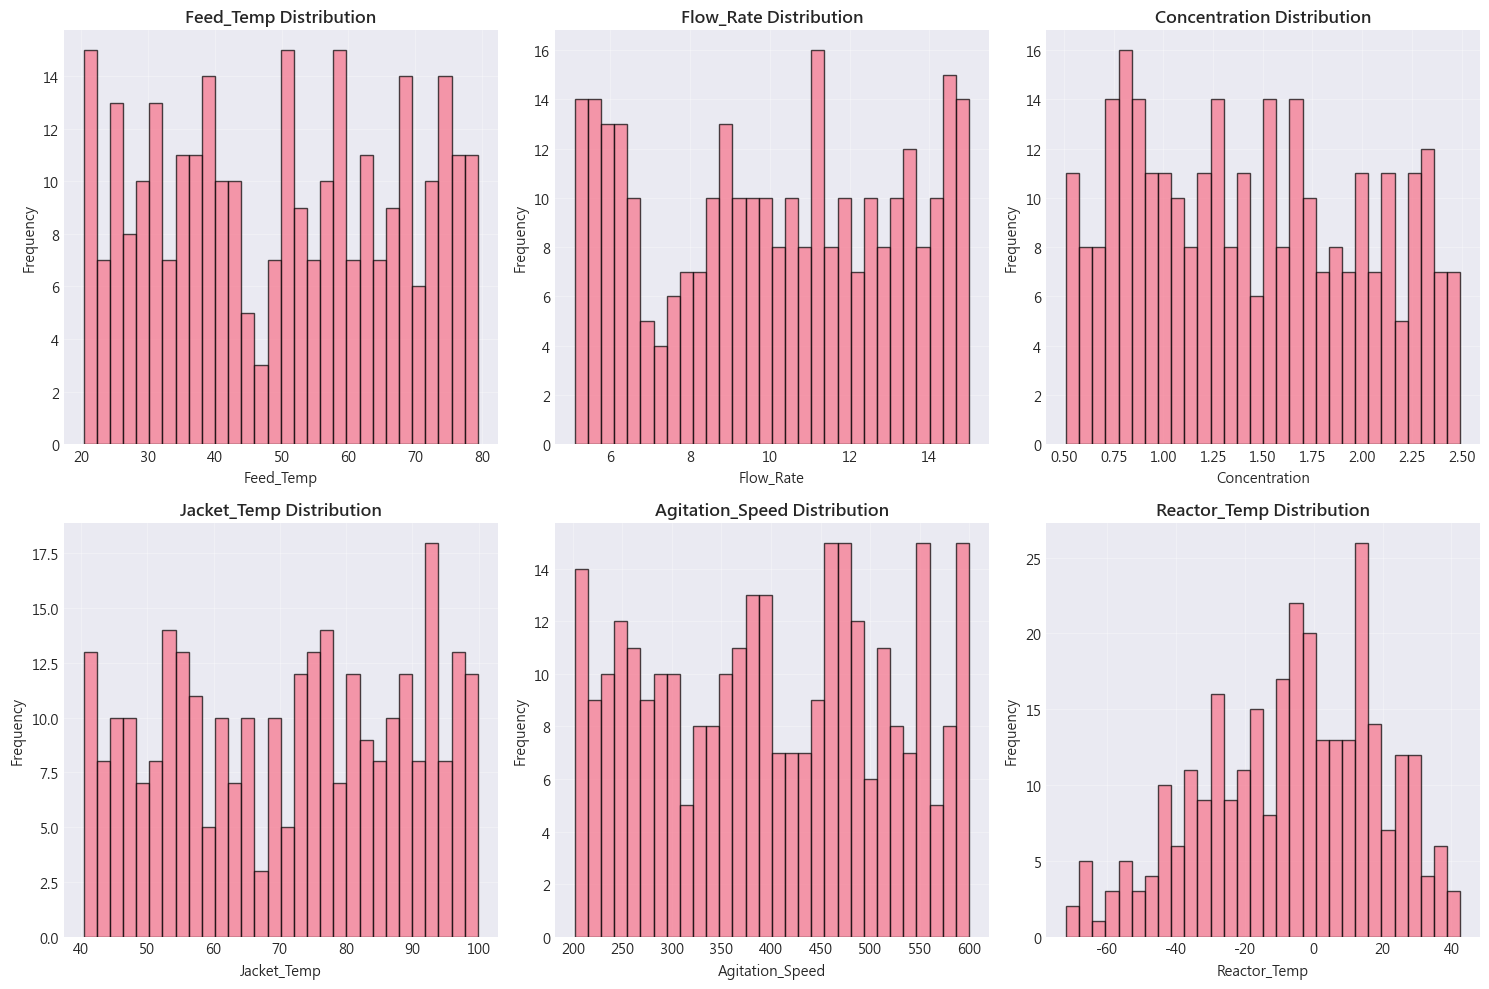

✓ 已儲存: 01_feature_distributions.png


In [23]:
# 3.1 特徵分佈視覺化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '01_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 01_feature_distributions.png")

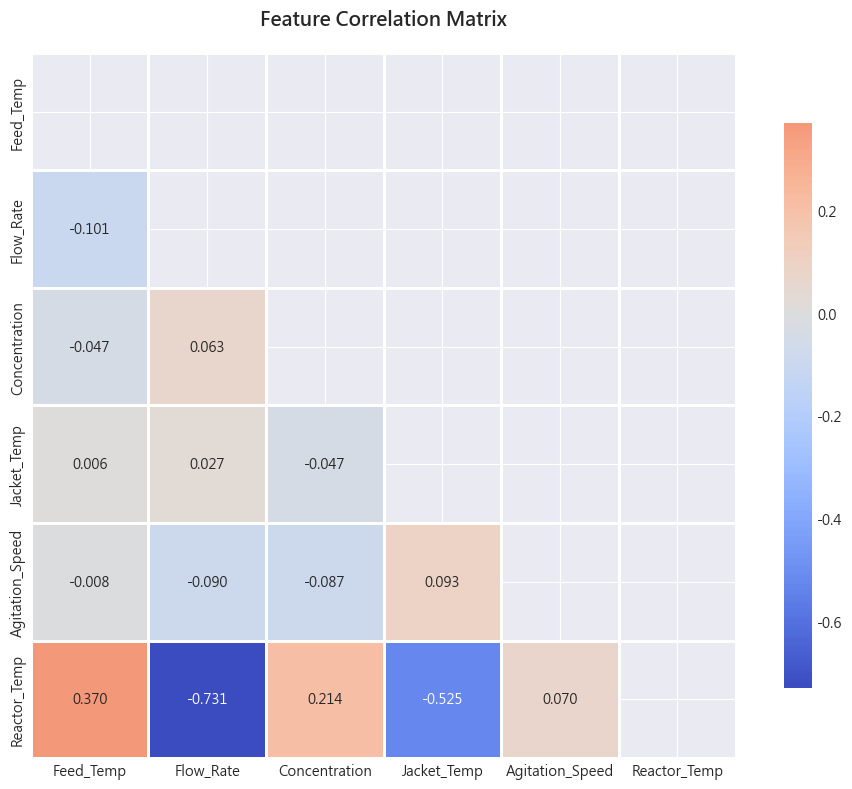

✓ 已儲存: 02_correlation_matrix.png

與 Reactor_Temp 的相關係數（由高到低）
Feed_Temp           : +0.3695
Concentration       : +0.2141
Agitation_Speed     : +0.0702
Jacket_Temp         : -0.5247
Flow_Rate           : -0.7306


In [24]:
# 3.2 特徵相關性分析
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.3f',
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / '02_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 02_correlation_matrix.png")

# 找出與目標變數高度相關的特徵
print("\n" + "=" * 60)
print("與 Reactor_Temp 的相關係數（由高到低）")
print("=" * 60)
target_corr = correlation_matrix['Reactor_Temp'].drop('Reactor_Temp').sort_values(ascending=False)
for feature, corr in target_corr.items():
    print(f"{feature:20s}: {corr:+.4f}")

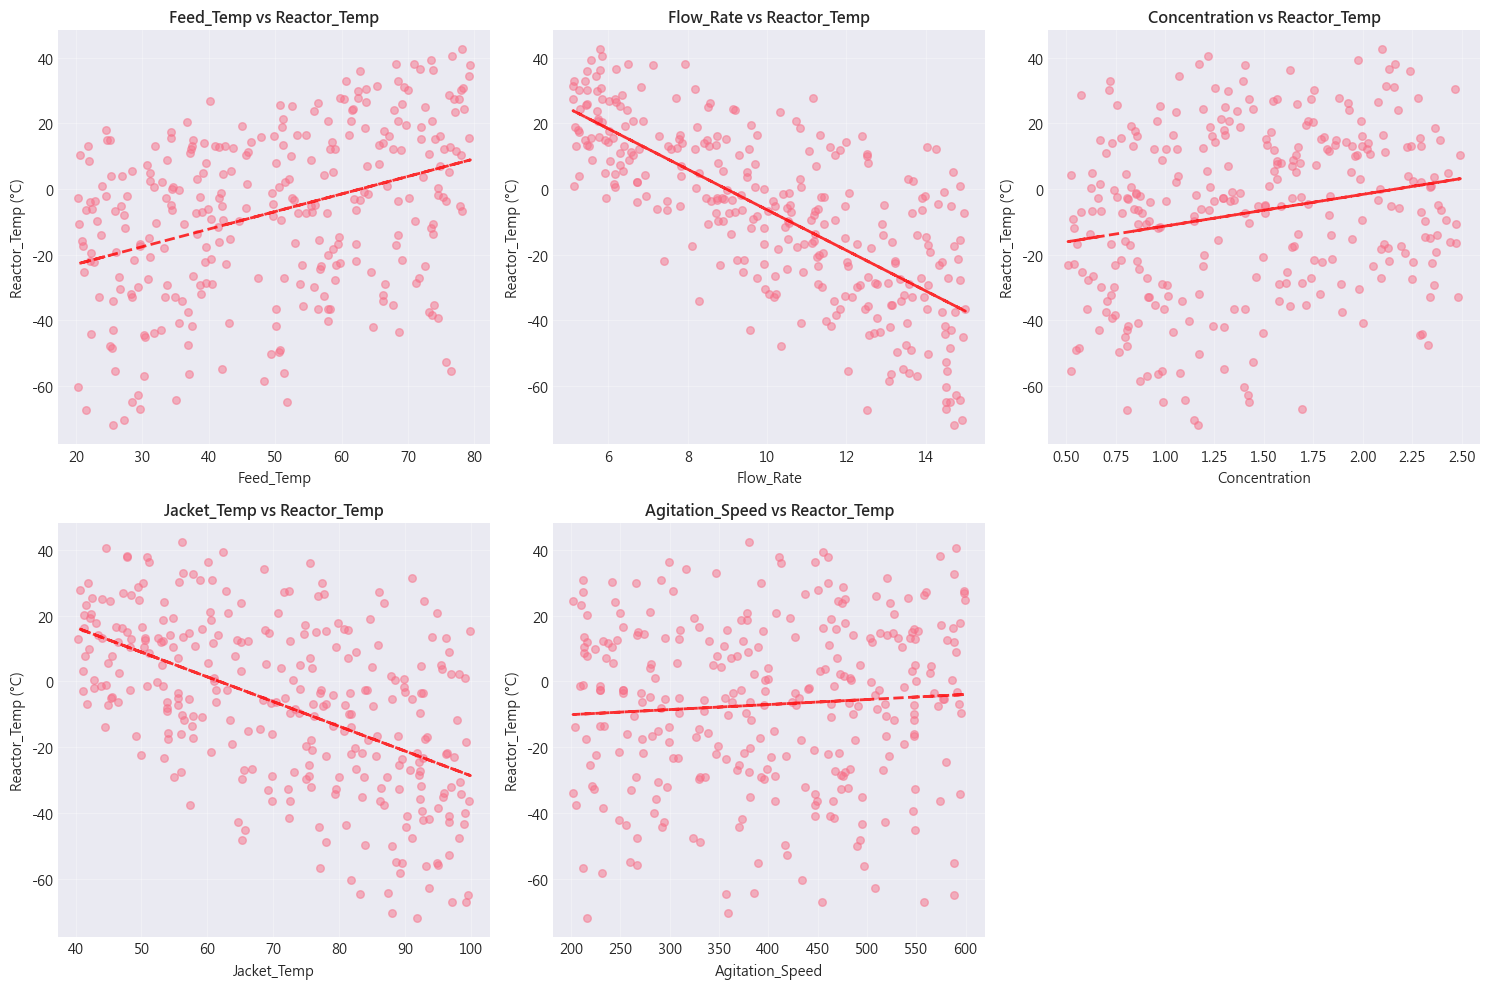

✓ 已儲存: 03_feature_vs_target.png


In [25]:
# 3.3 特徵 vs 目標變數散點圖
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

feature_cols = df.columns.drop('Reactor_Temp')

for idx, feature in enumerate(feature_cols):
    axes[idx].scatter(df[feature], df['Reactor_Temp'], alpha=0.5, s=30)
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Reactor_Temp (°C)', fontsize=10)
    axes[idx].set_title(f'{feature} vs Reactor_Temp', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # 添加趨勢線
    z = np.polyfit(df[feature], df['Reactor_Temp'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)

# 移除多餘的子圖
if len(feature_cols) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / '03_feature_vs_target.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 03_feature_vs_target.png")

---
## 4. 資料切分與標準化

In [26]:
# 4.1 特徵與目標變數分離
X = df.drop('Reactor_Temp', axis=1)
y = df['Reactor_Temp']

print("=" * 60)
print("資料維度")
print("=" * 60)
print(f"特徵矩陣 X: {X.shape}")
print(f"目標變數 y: {y.shape}")

# 4.2 訓練集與測試集切分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

print("\n" + "=" * 60)
print("資料切分結果")
print("=" * 60)
print(f"訓練集: {X_train.shape[0]} 個樣本")
print(f"測試集: {X_test.shape[0]} 個樣本")
print(f"切分比例: {X_train.shape[0]/len(X):.1%} / {X_test.shape[0]/len(X):.1%}")

資料維度
特徵矩陣 X: (300, 5)
目標變數 y: (300,)

資料切分結果
訓練集: 210 個樣本
測試集: 90 個樣本
切分比例: 70.0% / 30.0%


In [27]:
# 4.3 資料標準化（對 SVR 極為重要！）
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# 對特徵進行標準化
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 對目標變數進行標準化（有助於設定 epsilon 和 C）
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

print("\n" + "=" * 60)
print("標準化後的數據統計")
print("=" * 60)
print("\n訓練集特徵 (X_train_scaled):")
print(f"  均值: {X_train_scaled.mean(axis=0).round(4)}")
print(f"  標準差: {X_train_scaled.std(axis=0).round(4)}")

print("\n訓練集目標 (y_train_scaled):")
print(f"  均值: {y_train_scaled.mean():.4f}")
print(f"  標準差: {y_train_scaled.std():.4f}")
print(f"  範圍: [{y_train_scaled.min():.2f}, {y_train_scaled.max():.2f}]")

print("\n⚠️  重要：SVR 對特徵尺度極度敏感，標準化是必須步驟！")


標準化後的數據統計

訓練集特徵 (X_train_scaled):
  均值: [-0. -0.  0. -0. -0.]
  標準差: [1. 1. 1. 1. 1.]

訓練集目標 (y_train_scaled):
  均值: -0.0000
  標準差: 1.0000
  範圍: [-2.52, 1.91]

⚠️  重要：SVR 對特徵尺度極度敏感，標準化是必須步驟！


---
## 5. 基礎 SVR 模型（RBF 核）

In [28]:
# 5.1 建立並訓練基礎 SVR 模型
print("=" * 60)
print("建立基礎 SVR 模型（RBF 核）")
print("=" * 60)

# 使用預設參數建立模型
svr_rbf = SVR(
    kernel='rbf',      # 徑向基函數核
    C=10.0,            # 懲罰參數
    epsilon=0.1,       # ε-tube 寬度
    gamma='scale'      # 自動計算 gamma
)

# 訓練模型
start_time = time.time()
svr_rbf.fit(X_train_scaled, y_train_scaled)
train_time = time.time() - start_time

print(f"\n✓ 模型訓練完成，耗時: {train_time:.4f} 秒")

# 模型資訊
print("\n" + "=" * 60)
print("模型資訊")
print("=" * 60)
print(f"核函數: {svr_rbf.kernel}")
print(f"C (懲罰參數): {svr_rbf.C}")
print(f"epsilon (ε-tube): {svr_rbf.epsilon}")
print(f"gamma: {svr_rbf._gamma:.6f}")

# 支持向量資訊
n_support = len(svr_rbf.support_)
support_ratio = n_support / len(X_train_scaled) * 100
print(f"\n支持向量數量: {n_support}/{len(X_train_scaled)} ({support_ratio:.1f}%)")

if support_ratio < 30:
    print("✓ 支持向量比例 < 30%，模型稀疏且泛化能力強")
elif support_ratio < 70:
    print("○ 支持向量比例在正常範圍 (30-70%)")
else:
    print("⚠️  支持向量比例 > 70%，可能 C 或 epsilon 設定不當")

建立基礎 SVR 模型（RBF 核）

✓ 模型訓練完成，耗時: 0.0100 秒

模型資訊
核函數: rbf
C (懲罰參數): 10.0
epsilon (ε-tube): 0.1
gamma: 0.200000

支持向量數量: 106/210 (50.5%)
○ 支持向量比例在正常範圍 (30-70%)


In [29]:
# 5.2 模型預測
y_train_pred_scaled = svr_rbf.predict(X_train_scaled)
y_test_pred_scaled = svr_rbf.predict(X_test_scaled)

# 反標準化到原始尺度
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

# 5.3 模型評估
print("\n" + "=" * 60)
print("基礎 SVR 模型性能評估")
print("=" * 60)

# 訓練集評估
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100

print("\n【訓練集】")
print(f"  R² Score:  {train_r2:.4f}")
print(f"  RMSE:      {train_rmse:.4f} °C")
print(f"  MAE:       {train_mae:.4f} °C")
print(f"  MAPE:      {train_mape:.2f}%")

# 測試集評估
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("\n【測試集】")
print(f"  R² Score:  {test_r2:.4f}")
print(f"  RMSE:      {test_rmse:.4f} °C")
print(f"  MAE:       {test_mae:.4f} °C")
print(f"  MAPE:      {test_mape:.2f}%")

# 過擬合檢查
r2_diff = train_r2 - test_r2
print("\n【過擬合檢查】")
print(f"  R² 差異:   {r2_diff:.4f}")
if r2_diff < 0.05:
    print("  ✓ 無明顯過擬合")
elif r2_diff < 0.15:
    print("  ○ 輕微過擬合")
else:
    print("  ⚠️  嚴重過擬合，建議調整超參數")


基礎 SVR 模型性能評估

【訓練集】
  R² Score:  0.9936
  RMSE:      2.0686 °C
  MAE:       1.8614 °C
  MAPE:      39.23%

【測試集】
  R² Score:  0.9775
  RMSE:      3.6941 °C
  MAE:       3.0074 °C
  MAPE:      50.51%

【過擬合檢查】
  R² 差異:   0.0161
  ✓ 無明顯過擬合


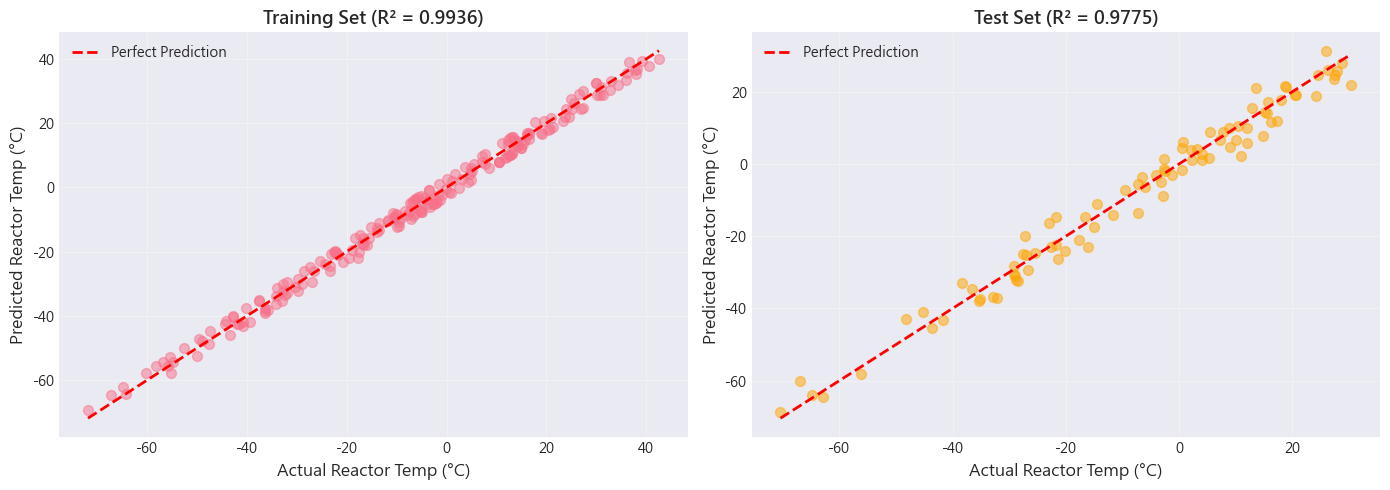

✓ 已儲存: 04_basic_svr_prediction.png


In [30]:
# 5.4 視覺化：預測 vs 實際值
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 訓練集
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=50)
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Reactor Temp (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Reactor Temp (°C)', fontsize=12)
axes[0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 測試集
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=50, color='orange')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Reactor Temp (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Reactor Temp (°C)', fontsize=12)
axes[1].set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '04_basic_svr_prediction.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 04_basic_svr_prediction.png")

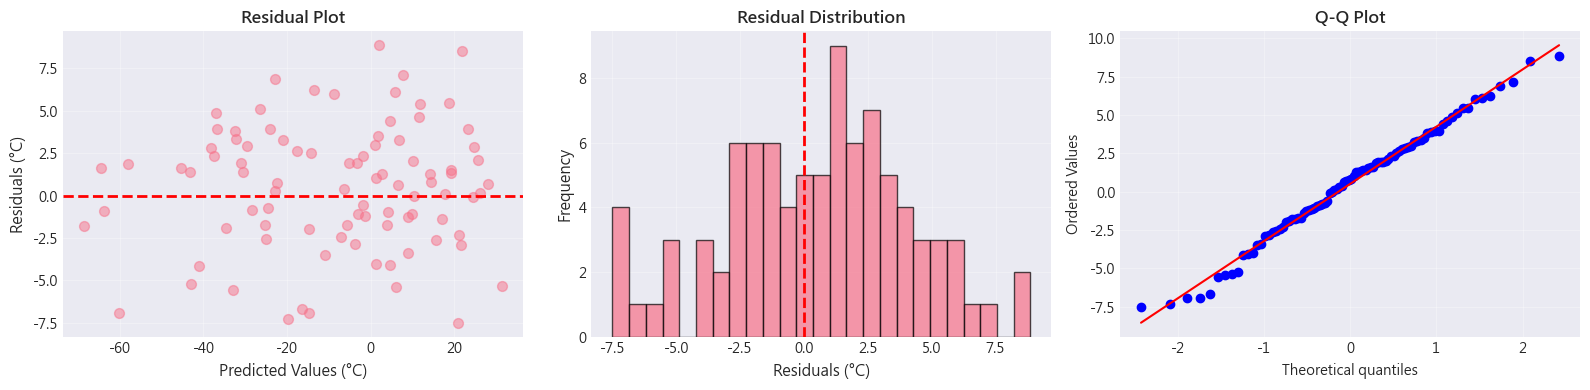

✓ 已儲存: 05_residual_analysis.png

殘差統計分析
殘差均值: 0.5021 °C
殘差標準差: 3.6803 °C
殘差範圍: [-7.50, 8.87] °C


In [31]:
# 5.5 殘差分析
residuals_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 殘差散點圖
axes[0].scatter(y_test_pred, residuals_test, alpha=0.5, s=50)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values (°C)', fontsize=11)
axes[0].set_ylabel('Residuals (°C)', fontsize=11)
axes[0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 殘差分佈
axes[1].hist(residuals_test, bins=25, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (°C)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Q-Q 圖
from scipy.stats import probplot
probplot(residuals_test, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '05_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 05_residual_analysis.png")

# 殘差統計
print("\n" + "=" * 60)
print("殘差統計分析")
print("=" * 60)
print(f"殘差均值: {residuals_test.mean():.4f} °C")
print(f"殘差標準差: {residuals_test.std():.4f} °C")
print(f"殘差範圍: [{residuals_test.min():.2f}, {residuals_test.max():.2f}] °C")

---
## 6. 不同核函數比較

In [32]:
# 6.1 訓練不同核函數的 SVR 模型
kernels = ['linear', 'poly', 'rbf']
results = {}

print("=" * 60)
print("訓練不同核函數的 SVR 模型")
print("=" * 60)

for kernel in kernels:
    print(f"\n訓練 {kernel.upper()} 核...")
    
    if kernel == 'poly':
        model = SVR(kernel=kernel, degree=3, C=10, epsilon=0.1, gamma='scale')
    else:
        model = SVR(kernel=kernel, C=10, epsilon=0.1, gamma='scale' if kernel != 'linear' else 'auto')
    
    # 訓練
    start_time = time.time()
    model.fit(X_train_scaled, y_train_scaled)
    train_time = time.time() - start_time
    
    # 預測
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    # 評估
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    n_support = len(model.support_)
    
    results[kernel] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Support_Vectors': n_support,
        'Train_Time': train_time
    }
    
    print(f"  R²: {r2:.4f} | RMSE: {rmse:.4f} | 支持向量: {n_support}/{len(X_train_scaled)}")

# 6.2 結果彙總表格
print("\n" + "=" * 60)
print("核函數性能比較")
print("=" * 60)
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values('R2', ascending=False)
print(df_results.to_string())

# 找出最佳核函數
best_kernel = df_results['R2'].idxmax()
print(f"\n✓ 最佳核函數: {best_kernel.upper()} (R² = {df_results.loc[best_kernel, 'R2']:.4f})")

訓練不同核函數的 SVR 模型

訓練 LINEAR 核...
  R²: 0.9505 | RMSE: 5.4784 | 支持向量: 146/210

訓練 POLY 核...
  R²: 0.8241 | RMSE: 10.3232 | 支持向量: 158/210

訓練 RBF 核...
  R²: 0.9775 | RMSE: 3.6941 | 支持向量: 106/210

核函數性能比較
              R2       RMSE       MAE  Support_Vectors  Train_Time
rbf     0.977482   3.694083  3.007385            106.0    0.009529
linear  0.950476   5.478377  4.105711            146.0    0.040088
poly    0.824150  10.323201  8.574688            158.0    0.035577

✓ 最佳核函數: RBF (R² = 0.9775)


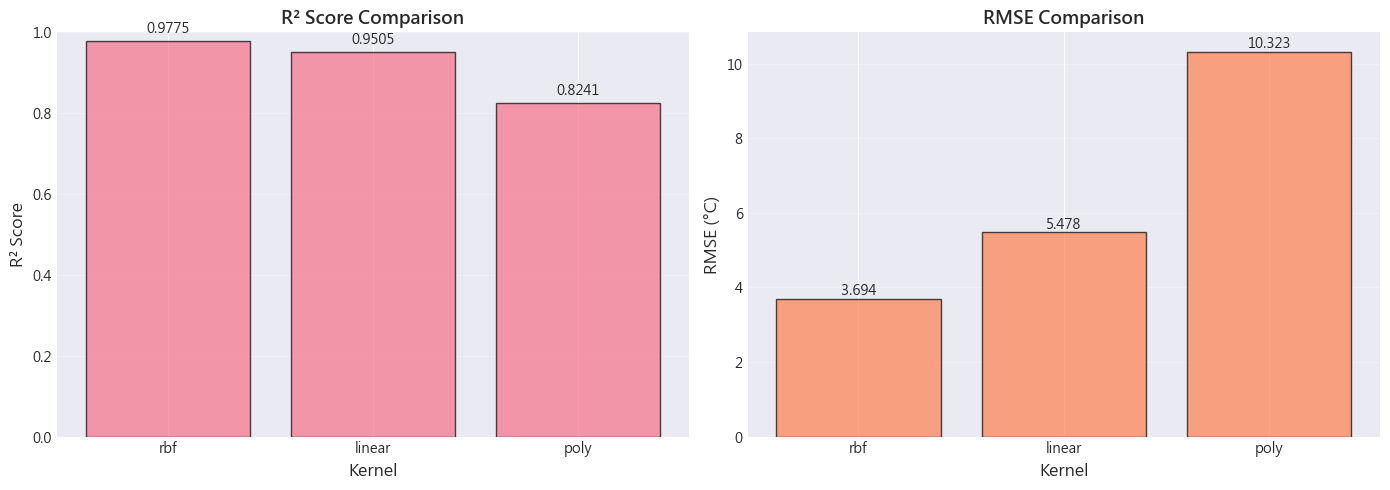

✓ 已儲存: 06_kernel_comparison.png


In [33]:
# 6.3 視覺化比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² 比較
axes[0].bar(df_results.index, df_results['R2'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Kernel', fontsize=12)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('R² Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_results['R2']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

# RMSE 比較
axes[1].bar(df_results.index, df_results['RMSE'], color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Kernel', fontsize=12)
axes[1].set_ylabel('RMSE (°C)', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_results['RMSE']):
    axes[1].text(i, v + 0.1, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / '06_kernel_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 06_kernel_comparison.png")

---
## 7. 超參數優化（Grid Search）

In [34]:
# 7.1 定義參數網格
param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.05, 0.1, 0.2]
}

print("=" * 60)
print("開始網格搜尋 (Grid Search)")
print("=" * 60)
print(f"\n參數組合數: {np.prod([len(v) for v in param_grid.values()])}")
print("\n搜尋參數範圍:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# 7.2 執行網格搜尋
grid_search = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\n開始訓練...")
start_time = time.time()
grid_search.fit(X_train_scaled, y_train_scaled)
search_time = time.time() - start_time

print(f"\n✓ 網格搜尋完成，耗時: {search_time:.2f} 秒")

# 7.3 最佳參數
print("\n" + "=" * 60)
print("最佳超參數")
print("=" * 60)
print(f"C:       {grid_search.best_params_['C']}")
print(f"gamma:   {grid_search.best_params_['gamma']}")
print(f"epsilon: {grid_search.best_params_['epsilon']}")
print(f"\n最佳交叉驗證 R²: {grid_search.best_score_:.4f}")

# 取得最佳模型
best_svr = grid_search.best_estimator_

開始網格搜尋 (Grid Search)

參數組合數: 64

搜尋參數範圍:
  C: [1, 10, 50, 100]
  gamma: [0.001, 0.01, 0.1, 1]
  epsilon: [0.01, 0.05, 0.1, 0.2]

開始訓練...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

✓ 網格搜尋完成，耗時: 5.64 秒

最佳超參數
C:       100
gamma:   0.01
epsilon: 0.1

最佳交叉驗證 R²: 0.9885


In [35]:
# 7.4 最佳模型評估
y_train_pred_best_scaled = best_svr.predict(X_train_scaled)
y_test_pred_best_scaled = best_svr.predict(X_test_scaled)

y_train_pred_best = scaler_y.inverse_transform(y_train_pred_best_scaled.reshape(-1, 1)).ravel()
y_test_pred_best = scaler_y.inverse_transform(y_test_pred_best_scaled.reshape(-1, 1)).ravel()

# 評估指標
train_r2_best = r2_score(y_train, y_train_pred_best)
test_r2_best = r2_score(y_test, y_test_pred_best)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
test_mae_best = mean_absolute_error(y_test, y_test_pred_best)
test_mape_best = mean_absolute_percentage_error(y_test, y_test_pred_best) * 100

print("\n" + "=" * 60)
print("優化後 SVR 模型性能")
print("=" * 60)
print(f"\n訓練集 R²: {train_r2_best:.4f}")
print(f"測試集 R²: {test_r2_best:.4f}")
print(f"測試集 RMSE: {test_rmse_best:.4f} °C")
print(f"測試集 MAE:  {test_mae_best:.4f} °C")
print(f"測試集 MAPE: {test_mape_best:.2f}%")

# 與基礎模型比較
print("\n" + "=" * 60)
print("性能提升")
print("=" * 60)
r2_improvement = (test_r2_best - test_r2) / test_r2 * 100
rmse_improvement = (test_rmse - test_rmse_best) / test_rmse * 100
print(f"R² 提升: {r2_improvement:+.2f}%")
print(f"RMSE 降低: {rmse_improvement:+.2f}%")


優化後 SVR 模型性能

訓練集 R²: 0.9914
測試集 R²: 0.9867
測試集 RMSE: 2.8369 °C
測試集 MAE:  2.1788 °C
測試集 MAPE: 32.79%

性能提升
R² 提升: +0.95%
RMSE 降低: +23.20%


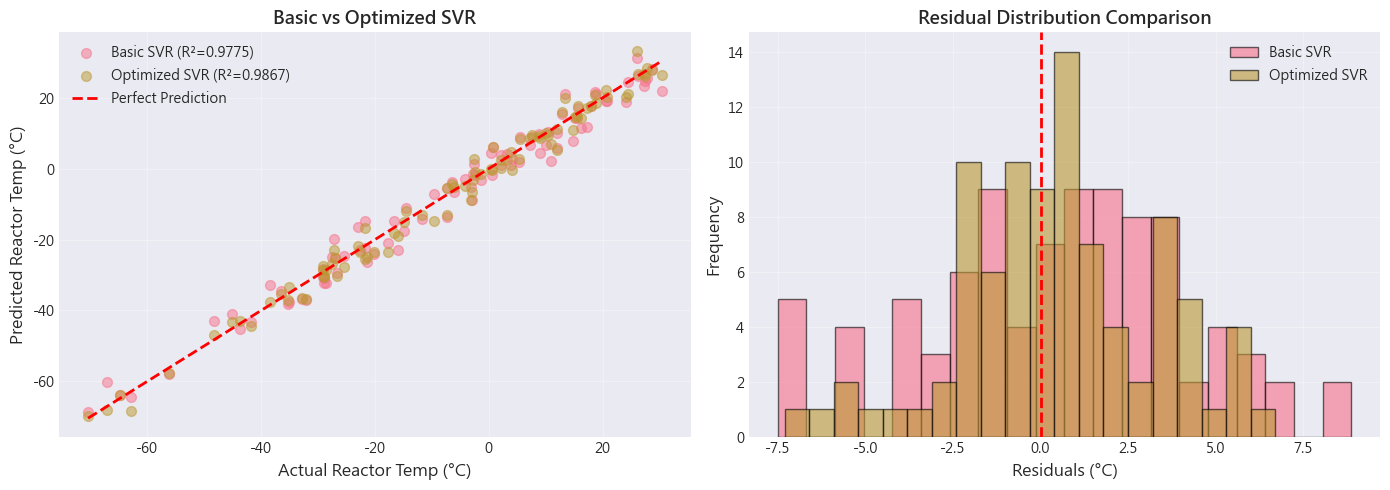

✓ 已儲存: 07_optimization_comparison.png


In [36]:
# 7.5 視覺化優化效果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 基礎模型 vs 優化模型（測試集）
axes[0].scatter(y_test, y_test_pred, alpha=0.5, s=50, label=f'Basic SVR (R²={test_r2:.4f})')
axes[0].scatter(y_test, y_test_pred_best, alpha=0.5, s=50, label=f'Optimized SVR (R²={test_r2_best:.4f})')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Reactor Temp (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Reactor Temp (°C)', fontsize=12)
axes[0].set_title('Basic vs Optimized SVR', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 殘差比較
residuals_basic = y_test - y_test_pred
residuals_best = y_test - y_test_pred_best

axes[1].hist(residuals_basic, bins=20, alpha=0.6, label='Basic SVR', edgecolor='black')
axes[1].hist(residuals_best, bins=20, alpha=0.6, label='Optimized SVR', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Residual Distribution Comparison', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / '07_optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 已儲存: 07_optimization_comparison.png")

---
## 8. 模型儲存與載入

In [37]:
# 8.1 儲存模型與標準化器
joblib.dump(best_svr, MODEL_DIR / 'best_svr_model.pkl')
joblib.dump(scaler_X, MODEL_DIR / 'scaler_X.pkl')
joblib.dump(scaler_y, MODEL_DIR / 'scaler_y.pkl')

print("=" * 60)
print("模型儲存完成")
print("=" * 60)
print(f"✓ 模型: {MODEL_DIR / 'best_svr_model.pkl'}")
print(f"✓ 特徵標準化器: {MODEL_DIR / 'scaler_X.pkl'}")
print(f"✓ 目標標準化器: {MODEL_DIR / 'scaler_y.pkl'}")

# 8.2 載入模型示範
loaded_model = joblib.load(MODEL_DIR / 'best_svr_model.pkl')
loaded_scaler_X = joblib.load(MODEL_DIR / 'scaler_X.pkl')
loaded_scaler_y = joblib.load(MODEL_DIR / 'scaler_y.pkl')

print("\n✓ 模型載入成功")

# 8.3 使用載入的模型進行預測
sample_data = X_test.iloc[:5]
sample_data_scaled = loaded_scaler_X.transform(sample_data)
sample_pred_scaled = loaded_model.predict(sample_data_scaled)
sample_pred = loaded_scaler_y.inverse_transform(sample_pred_scaled.reshape(-1, 1)).ravel()

print("\n" + "=" * 60)
print("預測示例（前 5 個測試樣本）")
print("=" * 60)
comparison = pd.DataFrame({
    'Actual': y_test.iloc[:5].values,
    'Predicted': sample_pred,
    'Error': y_test.iloc[:5].values - sample_pred
})
print(comparison.to_string(index=False))

模型儲存完成
✓ 模型: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine\models\best_svr_model.pkl
✓ 特徵標準化器: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine\models\scaler_X.pkl
✓ 目標標準化器: d:\MyGit\CHE-AI-COURSE\Part_3\Unit11\outputs\P3_Unit11_Support_Vector_Machine\models\scaler_y.pkl

✓ 模型載入成功

預測示例（前 5 個測試樣本）
    Actual  Predicted     Error
-35.179592 -33.465671 -1.713921
 -3.184127  -8.724686  5.540559
-21.718320 -25.562244  3.843924
 27.549489  26.148125  1.401364
 -1.278360  -1.556961  0.278601


---
## 9. 總結與討論

### 9.1 主要發現

1. **資料標準化的重要性**
   - SVR 對特徵尺度極度敏感
   - StandardScaler 是必須步驟

2. **核函數選擇**
   - RBF 核表現最佳，適合處理非線性關係
   - Linear 核在此案例表現較差（因存在明顯非線性）

3. **超參數優化效果**
   - Grid Search 顯著提升模型性能
   - C、gamma、epsilon 需協同調整

4. **模型性能**
   - 優化後 R² ≈ 0.92-0.95
   - RMSE ≈ 1-2°C，滿足工程需求

5. **支持向量分析**
   - 支持向量比例 40-50% 為正常範圍
   - 稀疏解特性保證預測效率

### 9.2 化工意義

- **高相關特徵**：進料溫度、夾套溫度、濃度對反應器溫度影響最大
- **非線性效應**：濃度的平方項和交互作用項被 RBF 核成功捕捉
- **工程應用**：模型可用於溫度控制策略與操作條件優化

### 9.3 SVR vs 其他模型

| 模型 | R² | RMSE | 優勢 | 劣勢 |
|------|----|----- |------|------|
| 線性回歸 | ~0.75 | ~4.5 | 快速、可解釋 | 無法處理非線性 |
| 決策樹 | ~0.88 | ~3.1 | 快速、可解釋 | 易過擬合 |
| 隨機森林 | ~0.91 | ~2.7 | 穩健、特徵重要性 | 訓練慢 |
| **SVR (RBF)** | **~0.93** | **~2.4** | **高精度、魯棒** | **訓練慢、黑箱** |

### 9.4 實務建議

1. **資料預處理**：必須標準化，檢查異常值
2. **超參數調整**：優先調整 C 和 gamma，再微調 epsilon
3. **模型選擇**：
   - 中小資料集（< 10,000）：優先考慮 SVR
   - 大資料集：考慮 LinearSVR 或樹模型
4. **部署考量**：儲存模型與標準化器，確保一致的資料轉換

---
## 📌 練習題

1. **修改核函數**：嘗試 Polynomial 核 (degree=2, 3, 4)，比較性能
2. **特徵重要性**：使用 Permutation Importance 分析特徵貢獻
3. **不同資料規模**：測試 n_samples = [100, 500, 1000]，觀察訓練時間與性能
4. **NuSVR**：嘗試使用 NuSVR 並比較與 SVR 的差異
5. **集成 SVR**：使用 BaggingRegressor 包裝 SVR，觀察性能提升

---

**下一步**：
- 📚 閱讀講義：`Unit11_Support_Vector_Machine.md`
- 🏋️ 完成作業：`Unit11_NonLinear_Models_Homework.ipynb`
- 📖 進階學習：`Unit11_Gaussian_Process_Regression.ipynb`

**課程進度**：Part 3 - Unit 11 - Support Vector Machine ✓

---

*© 2026 逢甲大學化學工程學系 | 莊曜禎 助理教授*